
# Risk-Parity Portfolio Optimization with [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/index.html)
--------
#### Source code:
#### [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/index.html) documentation

#### [Example](https://riskfolio-lib.readthedocs.io/en/latest/examples.html) codes
----

## Risk Parity
### Risk parity is a portfolio allocation strategy that uses risk to determine allocations across various components of an investment portfolio. The risk parity strategy modifies the modern portfolio theory (MPT) approach to investing through the use of leverage.


### MPT seeks to diversify an investment portfolio among specified assets to optimize returns while adhering to market risk parameters by viewing the risk and returns for the entire portfolio, but only utilizing long and unmargined positions. With risk parity strategies, portfolio managers can derive exact capital contribution proportions of asset classes in a portfolio to achieve optimized diversification for a range of objectives and investor preferences.

#### Source: [Investopedia](https://www.investopedia.com/terms/r/risk-parity.asp)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.ConstraintsFunctions as cf
import riskfolio.PlotFunctions as plf
import riskfolio.Reports as rp
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Pandas_datareader override
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

In [3]:
# Select date range to pull asset prices
start = '2016-01-01'
end = '2021-08-16'

In [4]:
# Select asset tickers
assets = ['BRK-B','ARKK','AGG','ETH-USD']
assets.sort()

In [5]:
# Downloading data from yfinance
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  4 of 4 completed


In [6]:
# Calculate returns
Y = data[assets].pct_change().dropna()
display(Y.head())


,AGG,ARKK,BRK-B,ETH-USD
Date,,,,
2016-01-05,0.0463%,0.7996%,0.3824%,-0.4509%
2016-01-06,0.3796%,-1.6857%,0.0610%,0.0720%
2016-01-07,-0.0092%,-3.9334%,-1.4087%,-0.9313%
2016-01-08,0.2213%,-1.1548%,-0.8882%,4.7541%
2016-01-09,0.0000%,0.0000%,0.0000%,0.0045%


In [7]:
# Create constraints either here or easier in excel (you can create more detailed constraints - see example codes)
asset_classes = {'Assets': ['AGG', 'ARKK', 'BRK-B', 'ETH-USD'],
                 'Class 1': ['Fixed Income', 'Equity', 'Equity', 'Crypto'],
                }
asset_classes = pd.DataFrame(asset_classes)
constraints = pd.read_excel('/Users/draganbogatic/Documents/Fin_Tech/portfolio_optimization/resources/constraints.xls',  index_col='Index')
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
Index,,,,,,,,,,
0,False,Classes,Class 1,Equity,>=,60.0000%,nan%,nan%,nan%,nan%
1,False,Classes,Class 1,Fixed Income,<=,30.0000%,nan%,nan%,nan%,nan%
2,False,Classes,Class 1,Crypto,<=,3.0000%,nan%,nan%,nan%,nan%
3,False,Assets,NaN,BRK-B,>=,30.0000%,nan%,nan%,nan%,nan%
4,False,Assets,NaN,BRK-B,<=,50.0000%,nan%,nan%,nan%,nan%


In [8]:
A, B = cf.assets_constraints(constraints, asset_classes)

In [9]:
# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data
method_cov='hist' # Method to estimate covariance matrix based on historical data
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

# Load constraints (you can optimize without constraints)
port.ainequality = A
port.binequality = B

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)


,AGG,ARKK,BRK-B,ETH-USD
weights,30.0000%,37.0000%,30.0000%,3.0000%


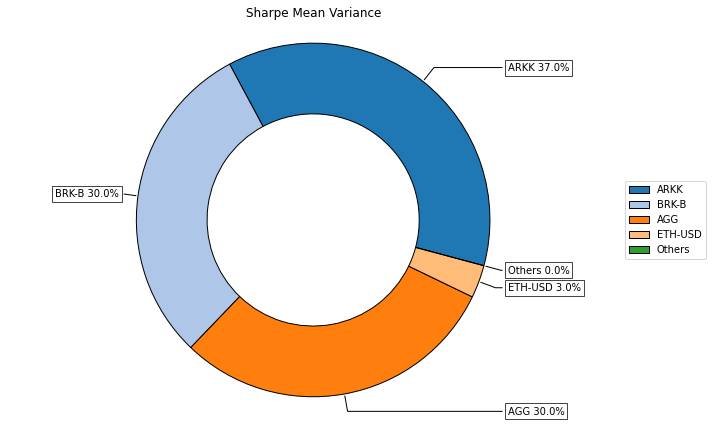

In [10]:
# Plotting the composition of the portfolio
ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.02, nrow=25, cmap = "tab20", height=6, width=10, ax=None)

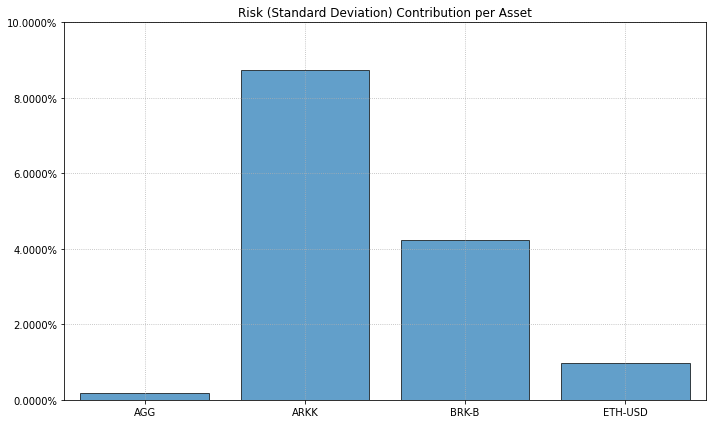

In [11]:
# Plotting the risk composition of the portfolio
ax = plf.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                       color="tab:blue", height=6, width=10, ax=None)

In [12]:
# Calculate risk parity for variance

b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w.T)

,AGG,ARKK,BRK-B,ETH-USD
weights,30.0000%,37.0000%,30.0000%,3.0000%


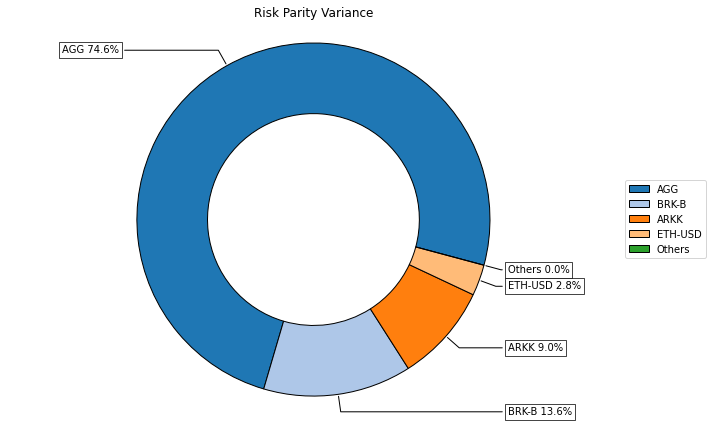

In [13]:
# Plotting portfolio composition based on risk parity
ax = plf.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.02, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

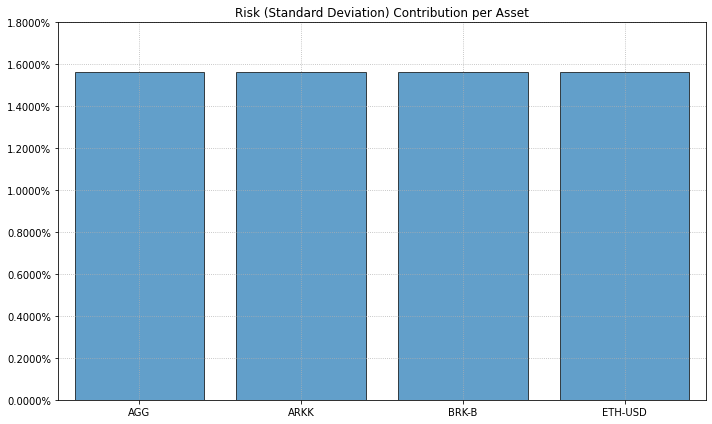

In [14]:
# Plotting risk composition
ax = plf.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                       color="tab:blue", height=6, width=10, ax=None)

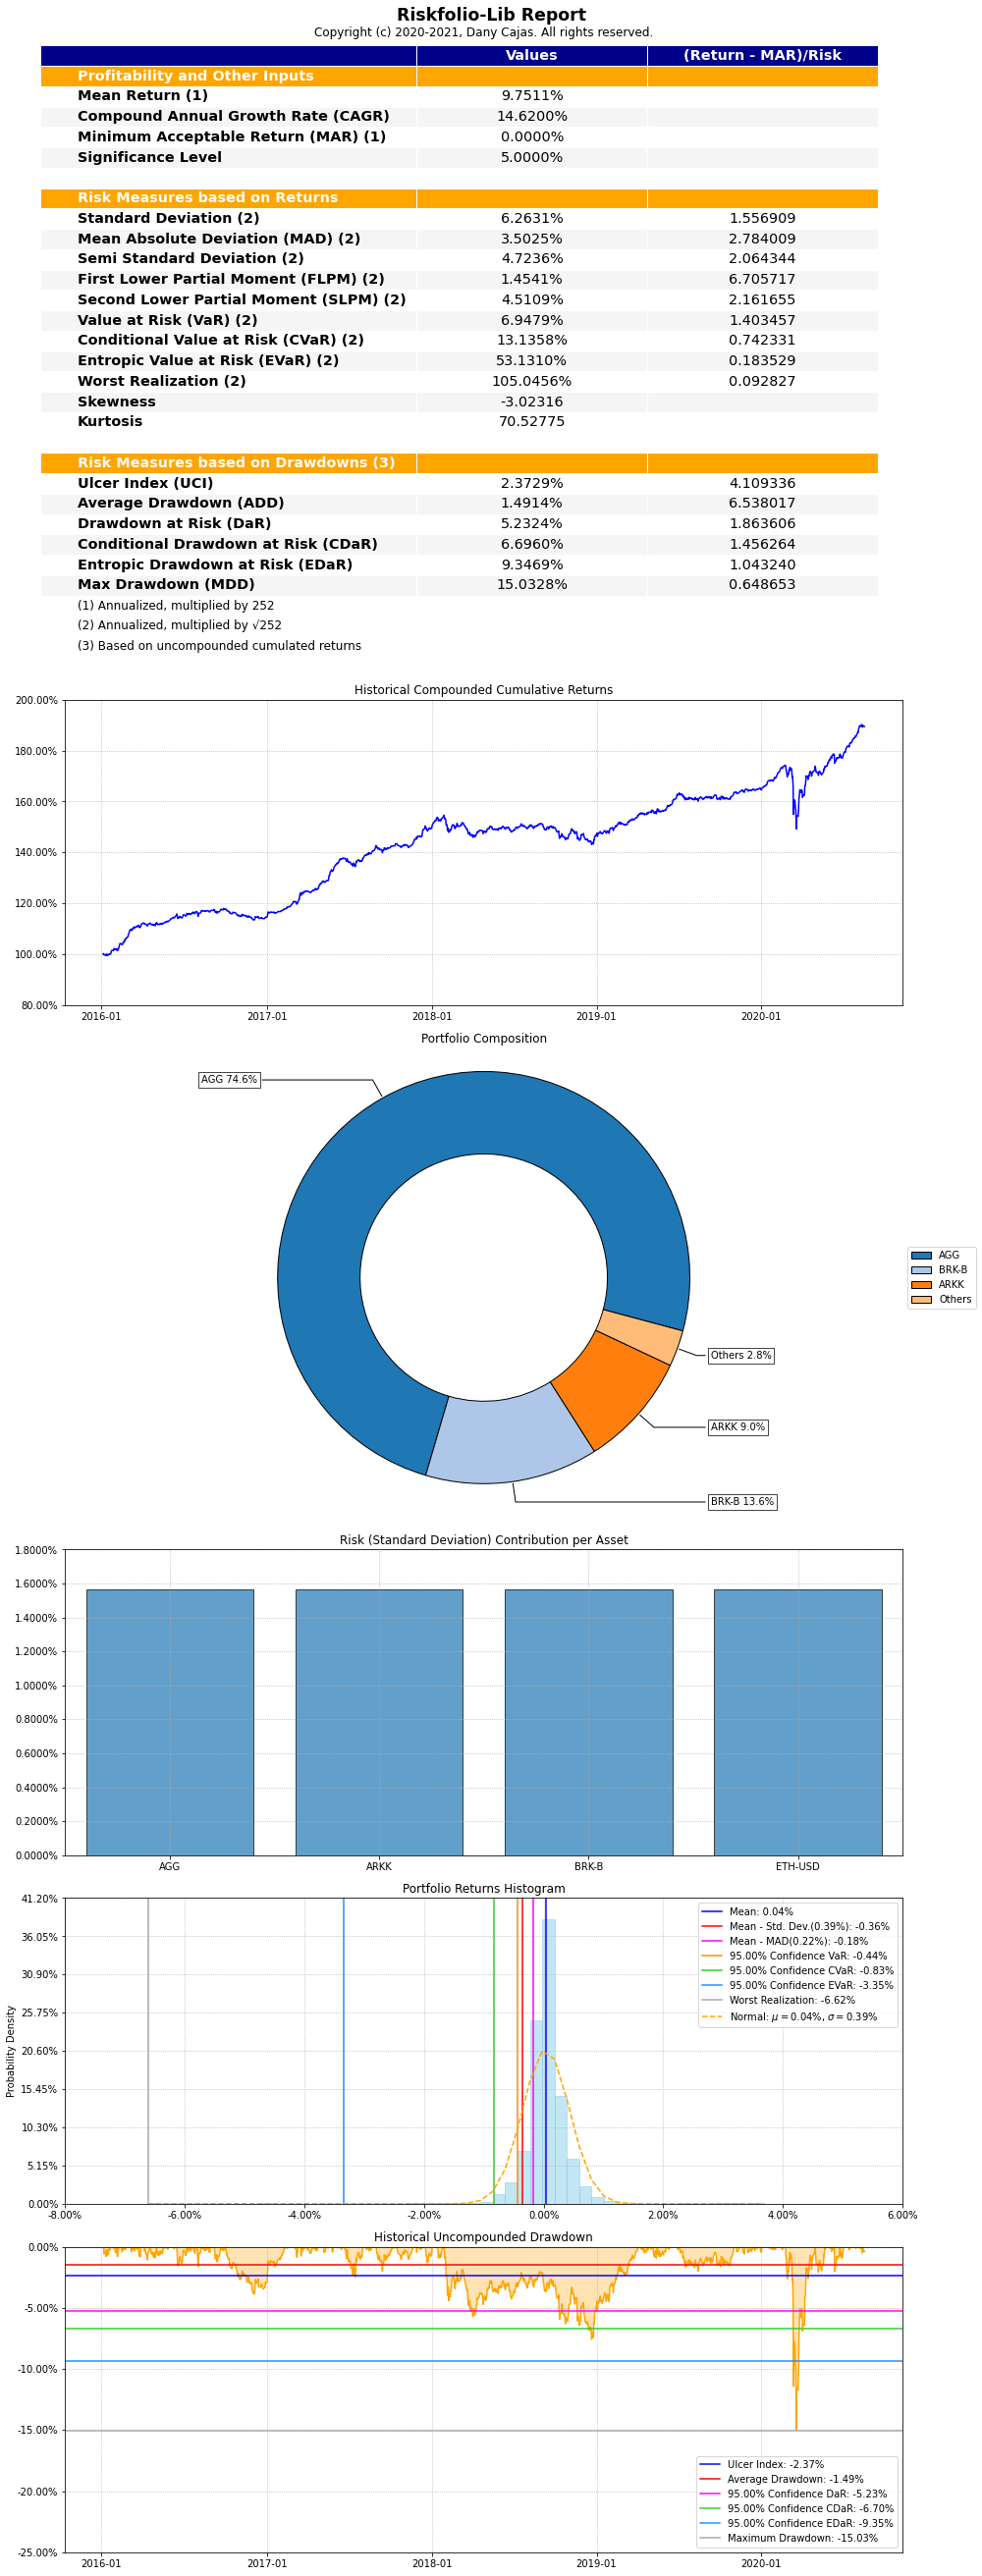

In [15]:
# Create portfolio report

returns = port.returns

ax = rp.jupyter_report(returns, w_rp, rm='MV', rf=0, alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)
